In [1]:
import numpy as np
from nozzle import Spectral, Params, Nozzle, Boundary
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import find_peaks

# Dirichlet boundary

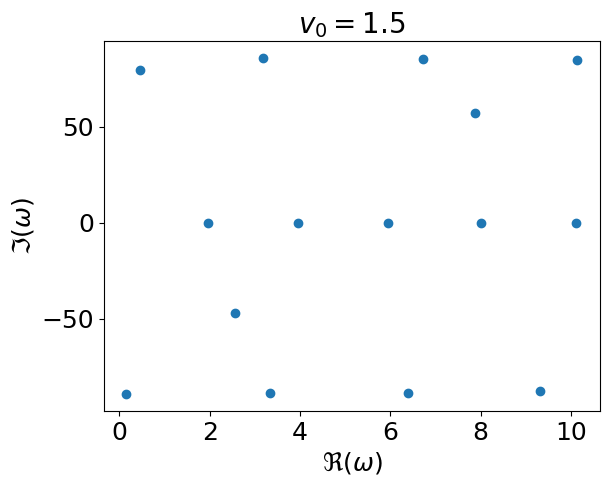

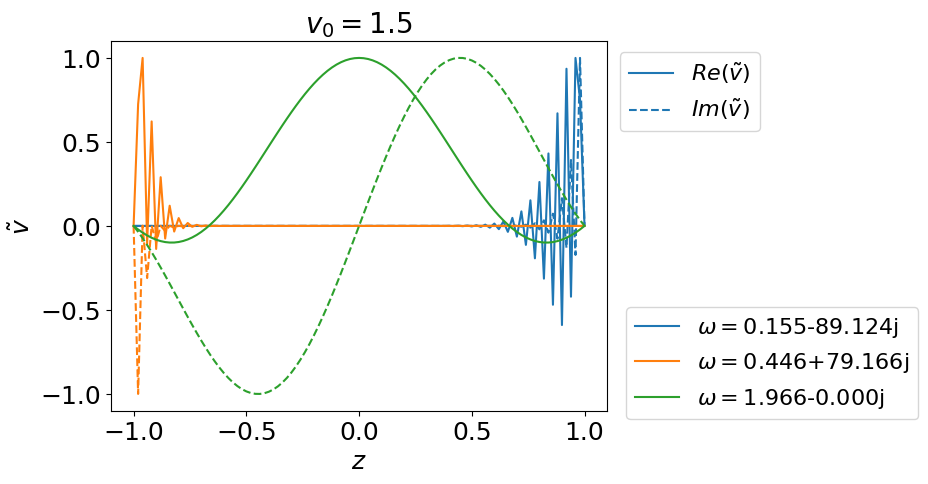

In [2]:
N = 101
Mm = 1.5
constant_v = True
accelerating = False
boundary = Boundary.FIXED_FIXED

params = Params(Mm, constant_v, accelerating, boundary)
spectral = Spectral(N, "symmetric", "FD")
nozzle = Nozzle(params, spectral.x)
v0 = nozzle.v0
n0 = np.exp(-0.5*v0**2)
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2
major = np.ones(N, dtype=complex)
minor = np.ones(N - 1, dtype=complex)
subminor = np.ones(N - 2, dtype=complex)
h = np.abs(nozzle.x[1] - nozzle.x[0])
D4 = (
        np.diag(6 / h**4 * major, k=0)
        + np.diag(-4 / h**4 * minor, k=1)
        + np.diag(-4 / h**4 * minor, k=-1)
        + np.diag(1 / h**4 * subminor, k=2)
        + np.diag(1 / h**4 * subminor, k=-2)
)
D4[0:1,:] = 0
D4[-2:-1,:] = 0
D4[0, :6] = np.array([3,-14,26,-24,11,-2]) / (h**4)
D4[1, 1:7] = np.array([3,-14,26,-24,11,-2]) / (h**4)
D4[-2, -7:-1] = np.array([2,-11,24,-26,14,-3]) / (h**4)
D4[-1, -6:] = np.array([2,-11,24,-26,14,-3]) / (h**4)

eta = 0.01
A11 = np.zeros_like(D1)
A12 = np.eye(*D1.shape)
A21 = -np.diag(1-v0**2)@D2 \
        + np.diag((3*v0 + 1/v0)*(D1@v0))@D1 \
        + np.diag((1-1/v0**2)*(D1@v0)**2) \
        + np.diag((v0+1/v0)*(D2@v0)) \
        # - eta*D4
A22 = -2j*(np.diag(v0)@D1 + np.diag(D1@v0)) # + eta*1j*np.diag(v0)@D4
A = np.block([[A11[1:-1,1:-1], A12[1:-1,1:-1]],
              [A21[1:-1,1:-1], A22[1:-1,1:-1]]])
nozzle.V, nozzle.omega = nozzle.solve(A)
nozzle.V = np.pad(nozzle.V, ((1,1),(0,0))) # pad two ends by 0
nozzle.sort_solutions(real_range=[0,11])#, imag_range=[-1,1])
ax1 = nozzle.plot_eigenvalues()
ax1.set_title("$v_0=1.5$")
ax2 = nozzle.plot_eigenfunctions(num_funcs=3)
legend = ax2.legend(["$Re(\\tilde{v})$", "$Im(\\tilde{v})$"], bbox_to_anchor=(1.33,1))
ax2.legend(bbox_to_anchor=(1.65,0.31))
ax2.add_artist(legend)
ax2.set_title("$v_0=1.5$")

nozzle.save_data("FD",N=N)

# Open Right End

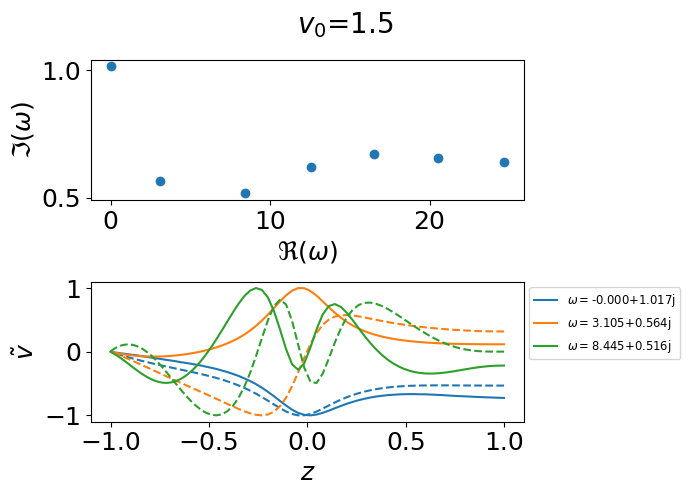

In [9]:
N = 101
Mm = 1.5
constant_v = False
accelerating = False
boundary = Boundary.FIXED_OPEN

params = Params(Mm, constant_v, accelerating, boundary)
spectral = Spectral(N, "symmetric", "CH")
nozzle = Nozzle(params, spectral.x)
v0 = nozzle.v0
x = spectral.x
dx = x[1] - x[0]
D1 = spectral.D1
D2 = spectral.D2
D1v = D1
D2v = D2
D1v[1,:] = D1[1,:] - D1[1,0]/D1[0,0]*D1[0,:]
D2v[1,:] = D2[1,:] - D2[1,0]/D1[0,0]*D1[0,:]

A11 = np.zeros_like(D1)
A12 = np.eye(*D1.shape)
A21 = -np.diag(1-v0**2)@D2v \
        + np.diag((3*v0 + 1/v0)*(D1@v0))@D1v \
        + np.diag((1-1/v0**2)*(D1@v0)**2) \
        + np.diag((v0+1/v0)*(D2@v0))
A22 = -2j*(np.diag(v0)@D1v + np.diag(D1@v0))

A = np.block([[A11[:-1,:-1], A12[:-1,:-1]],
              [A21[:-1,:-1], A22[:-1,:-1]]])
V, nozzle.omega = nozzle.solve(A)
# modify the last row
V = np.pad(V,((1,0),(0,0)))
for j in range(V.shape[1]):
        V[0,j] = -(D1[0,1:]@V[1:,j])/D1[0,0]
nozzle.V = V
nozzle.sort_solutions(real_range=[-0.1,25], imag_range=[-10,10])

fig, ax = plt.subplots(2,1, figsize=(7,5))
nozzle.plot_eigenvalues(ax=ax[0])
nozzle.plot_eigenfunctions(num_funcs=3,ax=ax[1])
ax[1].legend(fontsize="small", bbox_to_anchor=(1,1))
fig.suptitle(f"$v_0$={Mm}")
plt.tight_layout()

# nozzle.save_data("FD",N=N)

# Open right end (Finite difference)
Since the right end point is open, so the boundary point is constraint by interior points 
$$
0 = v_{n+1}' = \frac{3v_{n+1}-4v_n + v_{n-1}}{2h}
\Rightarrow
v_{n+1} = \frac{4}{3}v_n - \frac{1}{3}v_{n-1}
$$

This indicates that the derivatives at the last interior point should be modified as follows:
$$
v_{n}' = \frac{v_{n+1}-v_{n-1}}{2h} = \frac{1}{2h}\left(\frac{4}{3}v_{n} - \frac{4}{3}v_{n-1}\right) 
$$
$$
v_{n}'' = \frac{v_{n+1}-2v_{n}+v_{n-1}}{h^2} = \frac{1}{h^2}\left(-\frac{2}{3}v_{n} + \frac{2}{3}v_{n-1}\right) 
$$

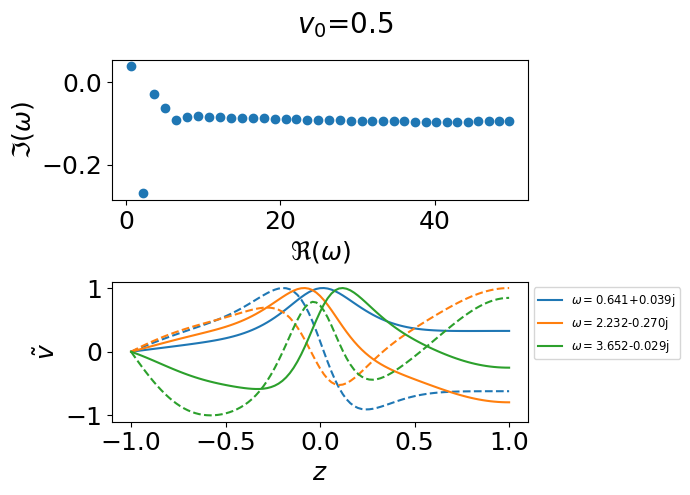

In [31]:
N = 101
Mm = 1.5
constant_v = False
accelerating = False
boundary = Boundary.FIXED_OPEN

params = Params(Mm, constant_v, accelerating, boundary)
spectral = Spectral(N, "symmetric", "FD")
nozzle = Nozzle(params, spectral.x)
v0 = nozzle.v0
x = spectral.x
dx = x[1] - x[0]
D1 = spectral.D1
D2 = spectral.D2
D1v = D1
D2v = D2
D1v[-2,:] = D1[-2,:] - D1[-2,-1]/D1[-1,-1]*D1[-1,:]
D2v[-2,:] = D2[-2,:] - D2[-2,-1]/D1[-1,-1]*D1[-1,:]

A11 = np.zeros_like(D1)
A12 = np.eye(*D1.shape)
A21 = -np.diag(1-v0**2)@D2v \
        + np.diag((3*v0 + 1/v0)*(D1@v0))@D1v \
        + np.diag((1-1/v0**2)*(D1@v0)**2) \
        + np.diag((v0+1/v0)*(D2@v0))
A22 = -2j*(np.diag(v0)@D1v + np.diag(D1@v0))

A = np.block([[A11[1:-1,1:-1], A12[1:-1,1:-1]],[A21[1:-1,1:-1], A22[1:-1,1:-1]]])
V, nozzle.omega = nozzle.solve(A)
# modify the last row
V = np.pad(V, ((1,1),(0,0))) # pad two ends by 0
for j in range(V.shape[1]):
    V[-1,j] = -(D1[-1,:-1]@V[:-1,j])/D1[-1,-1]
nozzle.V = V
del_ind = []
for i in range(nozzle.omega.size):
    zeros = np.isclose(nozzle.V[:,i].real,0).nonzero()[0]
    peaks = find_peaks(np.abs(nozzle.V[:,i].real/nozzle.V[:,i].real.max()), prominence=0.1)[0]
    if (
        (zeros.size > nozzle.x.size//3) # noise
        or (peaks.size > 1 and (peaks < nozzle.x.size//2).all()) # all peaks on the left (damped)
        or (peaks.size > 1 and (peaks > nozzle.x.size//2).all()) # all peaks on the right (damped)
        or (peaks.size > nozzle.x.size//3) # high k
    ):
        del_ind.append(i)
nozzle.omega = np.delete(nozzle.omega, del_ind)
nozzle.V = np.delete(nozzle.V, del_ind, axis=1)
# nozzle.sort_solutions(real_range=[-0.1,50], imag_range=[-1,1])
nozzle.sort_solutions(real_range=[-0.1,50])

fig, ax = plt.subplots(2,1, figsize=(7,5))
nozzle.plot_eigenvalues(ax=ax[0])
nozzle.plot_eigenfunctions(num_funcs=3,ax=ax[1])
ax[1].legend(fontsize="small", bbox_to_anchor=(1,1))
fig.suptitle(f"$v_0$={Mm}")
plt.tight_layout()

# nozzle.save_data("FD",N=N)